Import directory, audio, numerical and tensor libraries

In [78]:
from google.colab import drive
import os
import time

!pip install -q console-progressbar
from console_progressbar import ProgressBar

import librosa
from librosa import display
import IPython.display 
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense

from sklearn import preprocessing

Mount google drive and load audio samples from nested directories (GTZAN dataset)

In [2]:
drive_dir = "/content/drive/"

drive.mount(drive_dir, force_remount=False)

Mounted at /content/drive/


Define function to preprocess audio samples into a single colour channel spectogram to apply CNN on

In [86]:
def load_data(dataset_path, set_size = 0, split_rate = 0.2):
  assert set_size >= 0, 'Set cutoff size must be greater than 0'
  assert split_rate >= 0, 'Test-Train split must be greater than 0'

  start = time.time()

  # Collect genres and audio file paths
  GENRES = [genre_dir for genre_dir in os.listdir(gtzan_dir) if os.path.isdir(os.path.join(gtzan_dir, genre_dir))]
  ex = []
  labels = []
  for genre in GENRES:
    for track_name in os.listdir(os.path.join(gtzan_dir, genre)):
      if os.path.isfile(os.path.join(gtzan_dir, genre, track_name)):
        ex.append(os.path.join(gtzan_dir, genre, track_name))
        labels.append(os.path.join(gtzan_dir, genre))

  if not set_size:
    set_size = len(ex)
  
  ex = ex[:set_size]

  # Encode labels to integers
  label_encoder = preprocessing.LabelEncoder()
  train_labels = np.array(label_encoder.fit_transform(labels))

  y = to_categorical(train_labels, num_classes=10)

  """
    for i, sample in enumerate(ex):
      a = fft_audio(sample)
      np.concatenate(x, a)
      print(a.shape, x.shape)
      pb.print_progress_bar(int( 100 * i / len(ex))) 
  """
  x = np.asarray(list(map(lambda sample: fft_audio(sample), ex)))

  split_index = int((1 - split_rate) * x.shape[0])

  end = time.time()

  print("Loaded and transformed %d samples in %.2f seconds" % (x.shape[0], end - start))

  return (x[:split_index], y[:split_index]), (x[split_index:], y[split_index:])

def fft_audio (path):
  # Returns time series and sampling rate
  X, sampling_rate = librosa.load(path)

  # display(Audio(x, rate=sampling_rate))

  #plt.figure(figsize=(20, 8))
  # librosa.display.waveplot(X, sr=sampling_rate)

  # Run discret fourier transform on signal
  mel_spectrogram = librosa.feature.melspectrogram(X, sr=sampling_rate, hop_length=512,  )

  # Exponentiate spectogram to mel scale to account for limited human frequency sensitivity range
  mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

  #librosa.display.specshow(mel_spectrogram, y_axis='mel', fmax=8000, x_axis='time');

  # Add colour channel dimension (of rank 1)
  sample = np.expand_dims(mel_spectrogram, axis=2)

  return sample[:,:512,:]

Load Gtzan dataset from google drive

In [106]:
gtzan_dir = drive_dir + "My Drive/Datasets/gtzan/genres"

(x_train, y_train), (x_test, y_test) = load_data(gtzan_dir, 100)

Loaded and transformed 100 samples in 72.71 seconds


## Define our model

 - 3 x 3 Convolutional Kernel
 - 2 x 4 Max Pooling
 - 3 x 5 Convolutional Kernel
 - 2 x 4 Max Pooling
 - 32 Node Fully Connected Layer
 - 10 Node Fully Connected Layer (output)
 

In [94]:
def get_model(input_shape):

  model = Sequential()

  model.add(BatchNormalization(name='batch-norm' ))

  model.add(Conv2D(name="conv-1",
                    filters=64,
                    padding='same',
                    kernel_size=(3, 3),
                    activation='relu',
                    input_shape=input_shape))
  
  model.add(MaxPooling2D(name="pool-1",
                         pool_size=(2, 4)))

  model.add(Conv2D(name="conv-2",
                    filters=64,
                    padding='same',
                    kernel_size=(3, 5),
                    activation='relu'))
  
  model.add(MaxPooling2D(name="pool-2",
                         pool_size=(2, 4)))

  model.add(Flatten())

  model.add(Dense(units=32, 
                  activation='relu'))

  model.add(Dense(units=10, 
                  activation='softmax'))

  model.compile(optimizer= 'sgd',
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy']);

  return model

Training plot function

In [104]:
def plot_learning(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

Epoch 1/10
1/1 [==============================] - 0s 313ms/step - loss: 2.3388 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 152ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 154ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 157ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 146ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 148ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 156ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accur

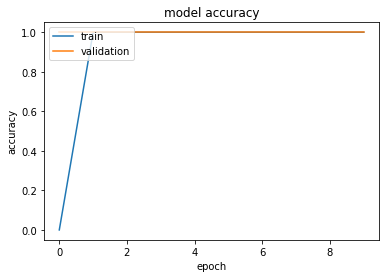

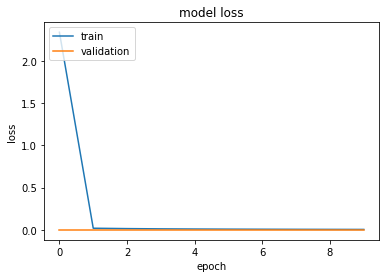

In [107]:
batch_size = 64
val_size = 60

input_shape = x_train.shape[1:]

model = get_model(input_shape)

history = model.fit(x_train[:-val_size],
                    y_train[:-val_size],
                    batch_size=batch_size,
                    epochs=10,
                    validation_split= 0.2,
                    shuffle=True)

plot_learning(history)